In [25]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np,os
import cv2

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [26]:
dir_name= "dataset/faces/"
y=[];X=[];target_names=[]
person_id=0;h=w=300
n_samples=0
class_names=[]
for person_name in os.listdir(dir_name):
    # print(person_name)
    dir_path = dir_name+person_name+"/"
    class_names.append(person_name)
    for image_name in os.listdir(dir_path):
        # formulate the image path
        image_path = dir_path+image_name
        # Read the input image
        img = cv2.imread(image_path)
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize image to 300*300 dimension
        resized_image= cv2.resize(gray,(h,w))
        # convert matrix to vector
        v = resized_image.flatten()
        X.append(v)
        # increase the number of samples
        n_samples =n_samples+1
        # Addinng th categorical label
        y.append(person_id)
        # adding the person name
        target_names.append(person_name)
    # Increase the person id by 1
    person_id=person_id+1
# #############################################################################
# transform list to numpy array
y=np.array(y)
X=np.array(X)
target_names =np.array(target_names)
n_features = X.shape[1]
print(y.shape,X.shape,target_names.shape)
# #############################################################################
# # Download the data, if not already on disk and load it as numpy arrays

# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# # introspect the images arrays to find the shapes (for plotting)
# n_samples, h, w = lfw_people.images.shape

# # for machine learning we use the 2 data directly (as relative pixel
# # positions info is ignored by this model)
# X = lfw_people.data
# n_features = X.shape[1]

# # the label to predict is the id of the person
# y = lfw_people.target
# target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


(450,) (450, 90000) (450,)
Total dataset size:
n_samples: 450
n_features: 90000
n_classes: 450


In [27]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

# print("Extracting the top %d eigenfaces from %d faces"% (n_components, X_train.shape[0]))

# Applying PCA
pca = PCA(n_components=n_components, svd_solver='randomized',whiten=True).fit(X_train)



# # Generating eigenfaces
# eigenfaces = pca.components_.reshape((n_components, h, w))

# # plot the gallery of the most significative eigenfaces

# eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
# plot_gallery(eigenfaces, eigenface_titles, h, w)

# plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# %%Compute Fisherfaces
lda = LinearDiscriminantAnalysis()
#Compute LDA of reduced data
lda.fit(X_train_pca, y_train)

X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)
print("Project done...")

Projecting the input data on the eigenfaces orthonormal basis
Project done...


Accuracy: 68.14159292035399


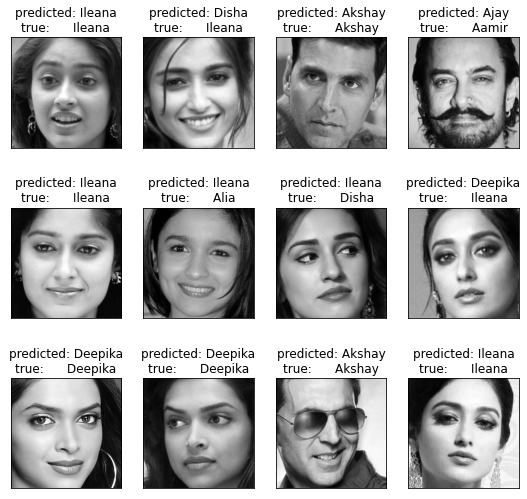

In [28]:
y_pred=[]
for test_face in X_test_lda:
    distances=[]
    # Find distance with all the faces
    for train_face in X_train_lda:
        d = np.linalg.norm(test_face-train_face)
        distances.append(d)
    # Finding the minimum distance
    minimum_distance=min(distances)
    # Finding the index of the closest fce
    index = distances.index(minimum_distance)
    # Find the label of the mathed face
    y_pred.append(y_train[index])

# Transform the data
y_pred = np.array(y_pred)
        

prediction_titles=[]
true_positive = 0
for i in range(y_pred.shape[0]):
    # true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    # pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]
    result = 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
    prediction_titles.append(result)
    if true_name==pred_name:
        true_positive =true_positive+1
        
print("Accuracy:",true_positive*100/y_pred.shape[0])
# Plot results
plot_gallery(X_test, prediction_titles, h, w)
plt.show()